In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
from slsim.image_simulation import lens_image_series, sharp_rgb_image
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.image_simulation import point_source_coordinate_properties
from slsim import lsst_science_pipeline
import matplotlib.pyplot as plt
import corner
import astropy.coordinates as coord
import astropy.units as u
import time

## Supernovae plus extended source simulation using OpSim
In this notebook, we simulate a population of lensed supernovae and simulated data of a random lensed supernovae, using the observing strategy from [OpSim](https://www.lsst.org/scientists/simulations/opsim). These are simulated databases with observations form the Vera Rubin Observatory that contain the distribution of bands, observing times, sky locations, psf, limiting magnitudes, sky brightness, and more. 

This notebook follows the following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Use OpSim to obtain the observation properties
4. Visualize the light curves and observations of the selected lens
4. Visualize time series of images of a selected lens

Before running this notebook, please download an OpSim database from [here](https://s3df.slac.stanford.edu/data/rubin/sim-data/) (for example, select ```sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db```). Place it in the folder ```../data/OpSim_database/```.

Additionally, download the SALT3.NIR_WAVEEXT directory from [here](https://github.com/LSST-strong-lensing/data_public/tree/main/sncosmo_sn_models) and place the directory in the folder ```../data/```. These files are a modified version of the type Ia models which have the lower and upper wavelength ranges extended.

## Simulate lens and source galaxy populations

In [2]:
# define a cosmology
H0 = 67.4
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)

# define sky area scaling
sky_area = Quantity(value=50, unit="deg2")

# define source and deflector sky areas (by keeping these low, the simulation is faster)
source_sky_area = Quantity(value=2, unit="deg2")
deflector_sky_area = Quantity(value=2, unit="deg2")

# define limits in the intrinsic deflector and source population
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 1.0}
kwargs_source_cut = {"z_min": 0.01, "z_max": 1.5}

start_time = time.time()

## create a point plus extended source lens population
supernova_lens_pop = LensPop(
    deflector_type="elliptical",  # type of the deflector. It could be elliptical or
    # all-galaxies.
    source_type="supernovae_plus_galaxies",  # keyword for source type. it can be
    # galaxies, quasar, quasar_plus_galaxies, and supernovae_plus_galaxies.
    kwargs_deflector_cut=kwargs_deflector_cut,  # cuts that one wants to apply for the
    # deflector.
    kwargs_source_cut=kwargs_source_cut,  # cuts that one wants to apply for the
    # source.
    variability_model="light_curve",  # keyword for the variability model.
    kwargs_variability={"supernovae_lightcurve", "g", "r", "i"},  # specify kewords for
    # lightcurve. "i" is a band for the lightcurve.
    sn_type="Ia",  # supernovae type.
    sn_absolute_mag_band="bessellb",  # Band used to normalize to absolute magnitude
    sn_absolute_zpsys="ab",  # magnitude system. It can be Optional, AB or Vega.
    sn_modeldir="../data/SALT3.NIR_WAVEEXT",  # extended wavelength models for SALT3
    kwargs_mass2light=None,  # mass-to-light relation for the deflector galaxy.
    skypy_config=None,  # Sky configuration for the simulation. If None, lsst-like
    # configuration will be used.
    sky_area=sky_area,  # Scaled sky area for the simulation
    source_sky_area=source_sky_area,
    deflector_sky_area=deflector_sky_area,
    cosmo=cosmo,  # astropy cosmology
    source_light_profile="single_sersic",  # light profile for the source galaxy
    catalog_type=None,  # catalog type. It can be None or scotch
    lightcurve_time=np.linspace(
        -50, 100, 1000
    ),  # array of light curve observation time.
    # catalog_path="../data/Scotch/"
    # + "scotch_SNIa_host_galaxies.fits",
    # path for catalog. If not provided, small size catalog from
    # /slsim/Source/SupernovaeCatalog will be used for
    # source_type="supernovae_plus_galaxies" case. For other cases, we do not need to
    # provide outside catalog. One can download scotch_SNIa_host_galaxies.fits from
    # https://github.com/LSST-strong-lensing/data_public.git
)
end_time = time.time()
print("Duration: ", np.around((end_time - start_time) / 60, 2), "minutes")

/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = integrate.quad(
/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The integral is

Duration:  2.12 minutes


In [3]:
print(
    "Found",
    supernova_lens_pop.deflector_number,
    "potential deflector galaxies and",
    supernova_lens_pop.source_number,
    "potential source galaxies.",
)

Found 2646425 potential deflector galaxies and 10650 potential source galaxies.


## Generate strong lensing systems and visualise properties

In [4]:
start_time = time.time()
# specifying cuts of the population
kwargs_lens_cuts = {}
# drawing population
supernovae_lens_population = supernova_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts, speed_factor=10000
)

end_time = time.time()
print(
    np.around((end_time - start_time) / 60, 2),
    "minutes needed to generate strong lenses.",
)
print("Number of strong lens systems:", len(supernovae_lens_population))

0.01 minutes needed to generate strong lenses.
Number of strong lens systems: 11


In [5]:
lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm host}$",
    r"$m_{\rm ps}$",
    r"$m_{\rm lens}$",
]

z_l = []
z_s = []

for supernovae_lens in supernovae_lens_population:

    z_l.append(supernovae_lens.deflector_redshift)
    z_s.append(supernovae_lens.source_redshift)

    vel_disp = supernovae_lens.deflector_velocity_dispersion()
    m_star = supernovae_lens.deflector_stellar_mass()
    theta_e = supernovae_lens.einstein_radius
    zl = supernovae_lens.deflector_redshift
    zs = supernovae_lens.source_redshift
    source_mag = supernovae_lens.extended_source_magnitude(band="i", lensed=True)
    ps_source_mag = supernovae_lens.point_source_magnitude(band="i")
    deflector_mag = supernovae_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [
            vel_disp,
            np.log10(m_star),
            theta_e,
            zl,
            zs,
            source_mag,
            ps_source_mag,
            deflector_mag,
        ]
    )

print("z_l = ", np.around(z_l, 2))
print("z_s = ", np.around(z_s, 2))

/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


z_l =  [0.09 0.49 0.19 0.46 0.2  0.52 0.4  0.14 0.47 0.39 0.51]
z_s =  [1.14 1.4  1.36 1.19 0.83 1.1  0.51 0.98 1.31 1.35 1.45]


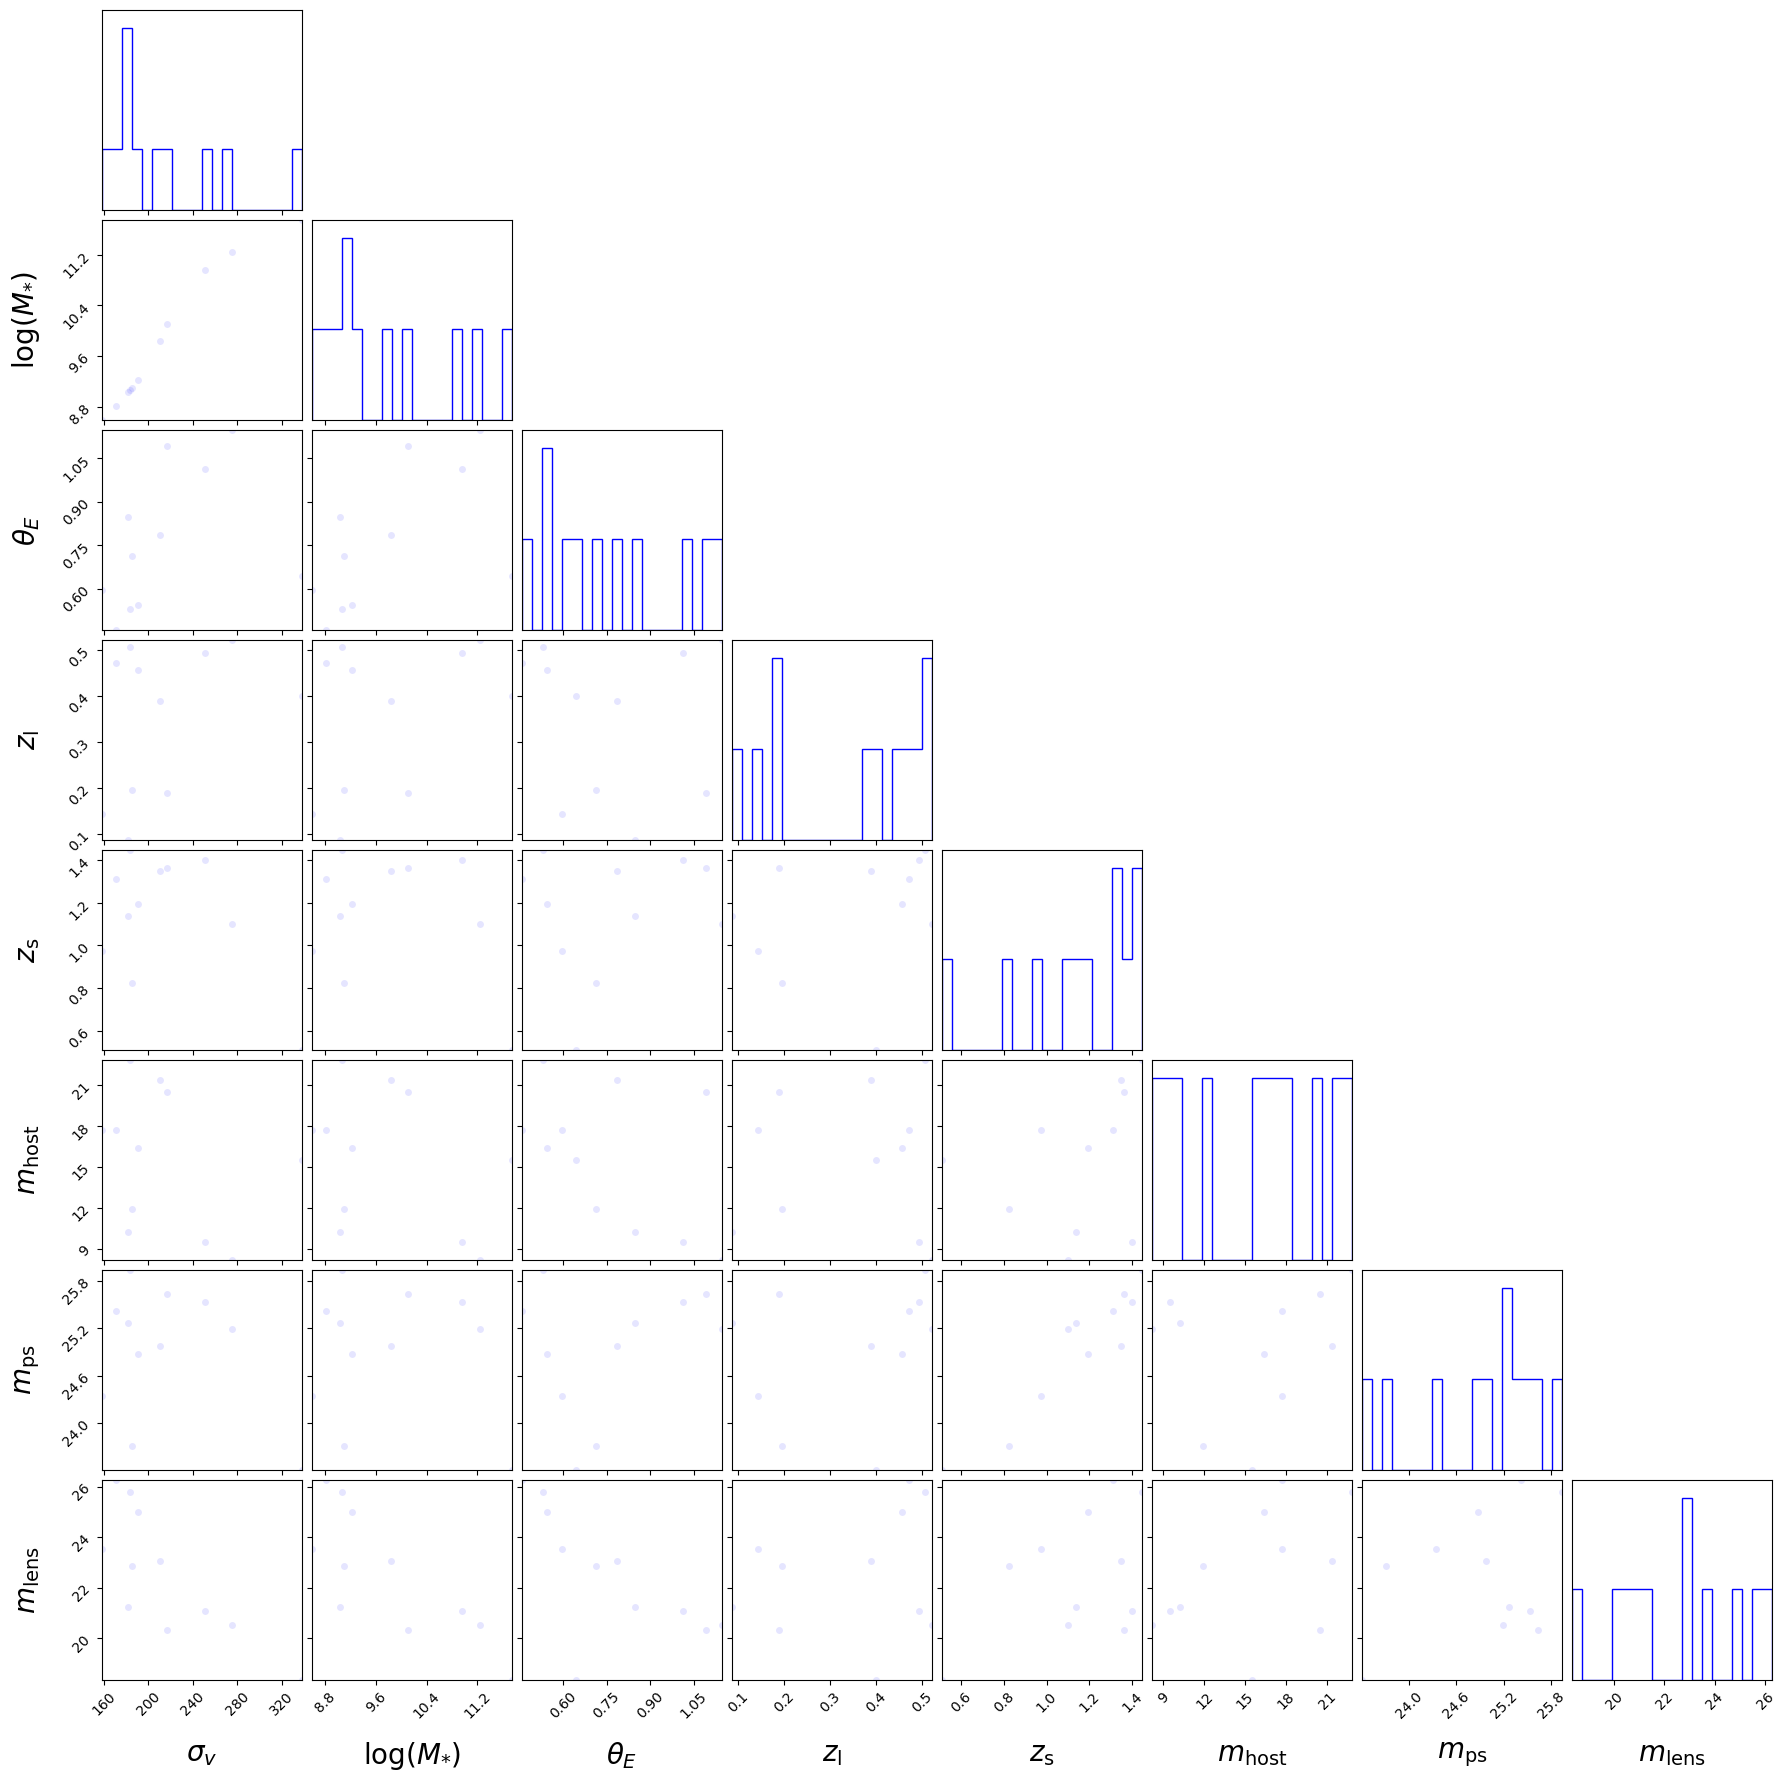

In [6]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(
    np.array(lens_samples), labels=labels, label_kwargs={"fontsize": 20}, **hist2dkwargs
)
plt.show()

## Choose one lens system to simulate LSST data

In [18]:
index = 3
# kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = supernovae_lens_population[index]

print("Chosen lens system properties:")
print(" ")
print("z_lens = ", lens_class.deflector_redshift)
print("z_source = ", lens_class.source.source_dict["z"])
print("theta_E = ", lens_class.einstein_radius)
print("Number of images = ", lens_class.image_number)
print("Time delays = ", lens_class.point_source_arrival_times())
print("Lens galaxy magnitude: ", lens_class.deflector_magnitude(band="i"))
print("Host galaxy magnitude: ", lens_class.source.source_dict["mag_i"])
print("Supernova magnitude: ", lens_class.source.source_dict["ps_mag_i"])

Chosen lens system properties:
 
z_lens =  0.456518871635215
z_source =  1.1928964311905985
theta_E =  0.5454736493768455
Number of images =  2
Time delays =  [-36.97353321   9.05872107]
Lens galaxy magnitude:  24.978525100468065
Host galaxy magnitude:  24.27685981162744
Supernova magnitude:  24.877955939141234


In [19]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=32,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

In [20]:
pix_coord

array([[13.13094119, 20.27229935],
       [15.38111176, 15.35063885]])

## See the light curve of a selected supernovae

This is a type Ia SN


(-50.0, 100.0)

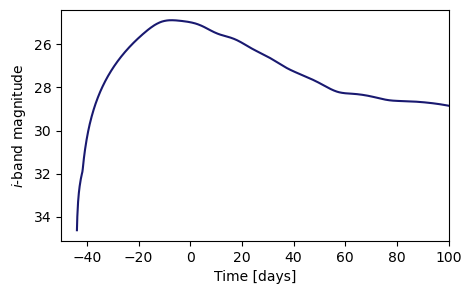

In [21]:
light_curve = lens_class.source.variability_class.kwargs_model

print("This is a type", lens_class.source.sn_type, "SN")

plt.figure(figsize=(5, 3))
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"], color="Midnightblue")
plt.gca().invert_yaxis()
plt.ylabel(r"$i$-band magnitude")
plt.xlabel("Time [days]")
plt.xlim(-50, 100)

## High-resolution rgb image

Text(0.5, 1.0, 'High-resolution RGB image')

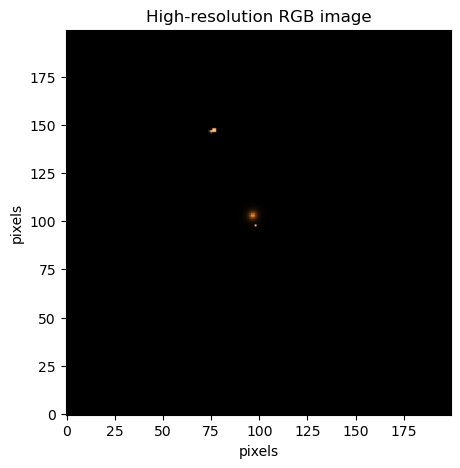

In [22]:
rgb_band_list = ["i", "r", "g"]

high_reso_rgb = sharp_rgb_image(
    lens_class=lens_class,
    rgb_band_list=rgb_band_list,
    mag_zero_point=28,
    delta_pix=0.02,
    num_pix=200,
)
plt.figure(figsize=(5, 5))
plt.imshow(high_reso_rgb, origin="lower")
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.title("High-resolution RGB image")

## Get observation properties from OpSim

Generate random points on the sky

In [12]:
N = 10

ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180 * u.degree)
dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180
dec_points = coord.Angle(dec_points * u.degree)

In [13]:
exposure_data = lsst_science_pipeline.opsim_time_series_images_data(
    ra_points,
    dec_points,
    "baseline_v3.0_10yrs",
    MJD_min=60000,
    MJD_max=60300,
    print_warning=True,
)

Reading from database sqlite:///../data/OpSim_database/baseline_v3.0_10yrs.db
Read N = 2086079 observations in 43.19 seconds.
No host file.
Coordinate (172.90991640808832 deg, 49.631056110355445 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (-109.93420854090337 deg, 60.24663542585676 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (73.54234401592636 deg, 62.41016024697848 deg) is not in the LSST footprint. This entry is skipped.


## Inject lensed SNe into empty image

using ```opsim_variable_lens_injection()```

images.keys() :  ['bkg_noise', 'psf_kernel', 'obs_time', 'expo_time', 'zero_point', 'calexp_center', 'band', 'lens', 'injected_lens']
 
29 observations


Text(0.5, 1.0, 'Injected lens system')

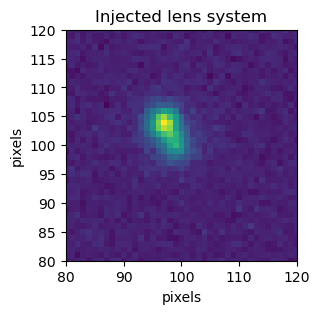

In [27]:
index = 0
bands = ["g", "r", "i"]
num_pix = 200
transform_pix2angle = np.array([[0.2, 0], [0, 0.2]])

images = lsst_science_pipeline.opsim_variable_lens_injection(
    lens_class, bands, num_pix, transform_pix2angle, exposure_data[index]
)
print("images.keys() : ", images.keys())
print(" ")
print(len(images["obs_time"]), "observations")

plt.figure(figsize=(3, 3))
plt.imshow(images["lens"][0], origin="lower")
plt.xlim(80, 120)
plt.ylim(80, 120)
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.title("Injected lens system")

## Compute time series of images
Using ```lens_image_series()``` with OpSim input for ```band, mag_zero_point, psf_kernel, exposure_time, t_obs```.

In [28]:
im_times = images["obs_time"] - images["obs_time"][0] - 20
repeats = len(im_times)
transform_matrix = np.array([[0.2, 0], [0, 0.2]])
transform_matrix_list = [transform_matrix]
transform_matrix_all = transform_matrix_list * repeats

# Simulate a lens image
images_opsim = lens_image_series(
    lens_class=lens_class,
    band=list(images["band"]),
    mag_zero_point=images["zero_point"],
    num_pix=32,
    psf_kernel=images["psf_kernel"],
    transform_pix2angle=transform_matrix_all,
    exposure_time=images["expo_time"],
    t_obs=im_times,
    with_deflector=True,
    with_source=True,
)

/var/folders/6x/j1tbqdk91439t5vn1y800sb40000gn/T/ipykernel_10201/1074870882.py:4: RuntimeWarning: divide by zero encountered in log10
  log_images.append(np.log10(images_opsim[i]))


Text(0.5, 1.0, 'log-scale image')

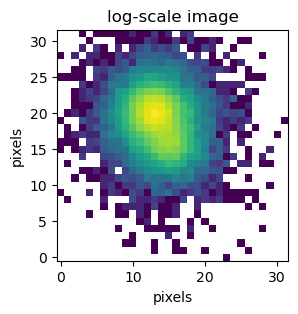

In [29]:
## Images in log scale
log_images = []
for i in range(len(images_opsim)):
    log_images.append(np.log10(images_opsim[i]))

plt.figure(figsize=(3, 3))
plt.imshow(log_images[0], origin="lower")
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.title("log-scale image")

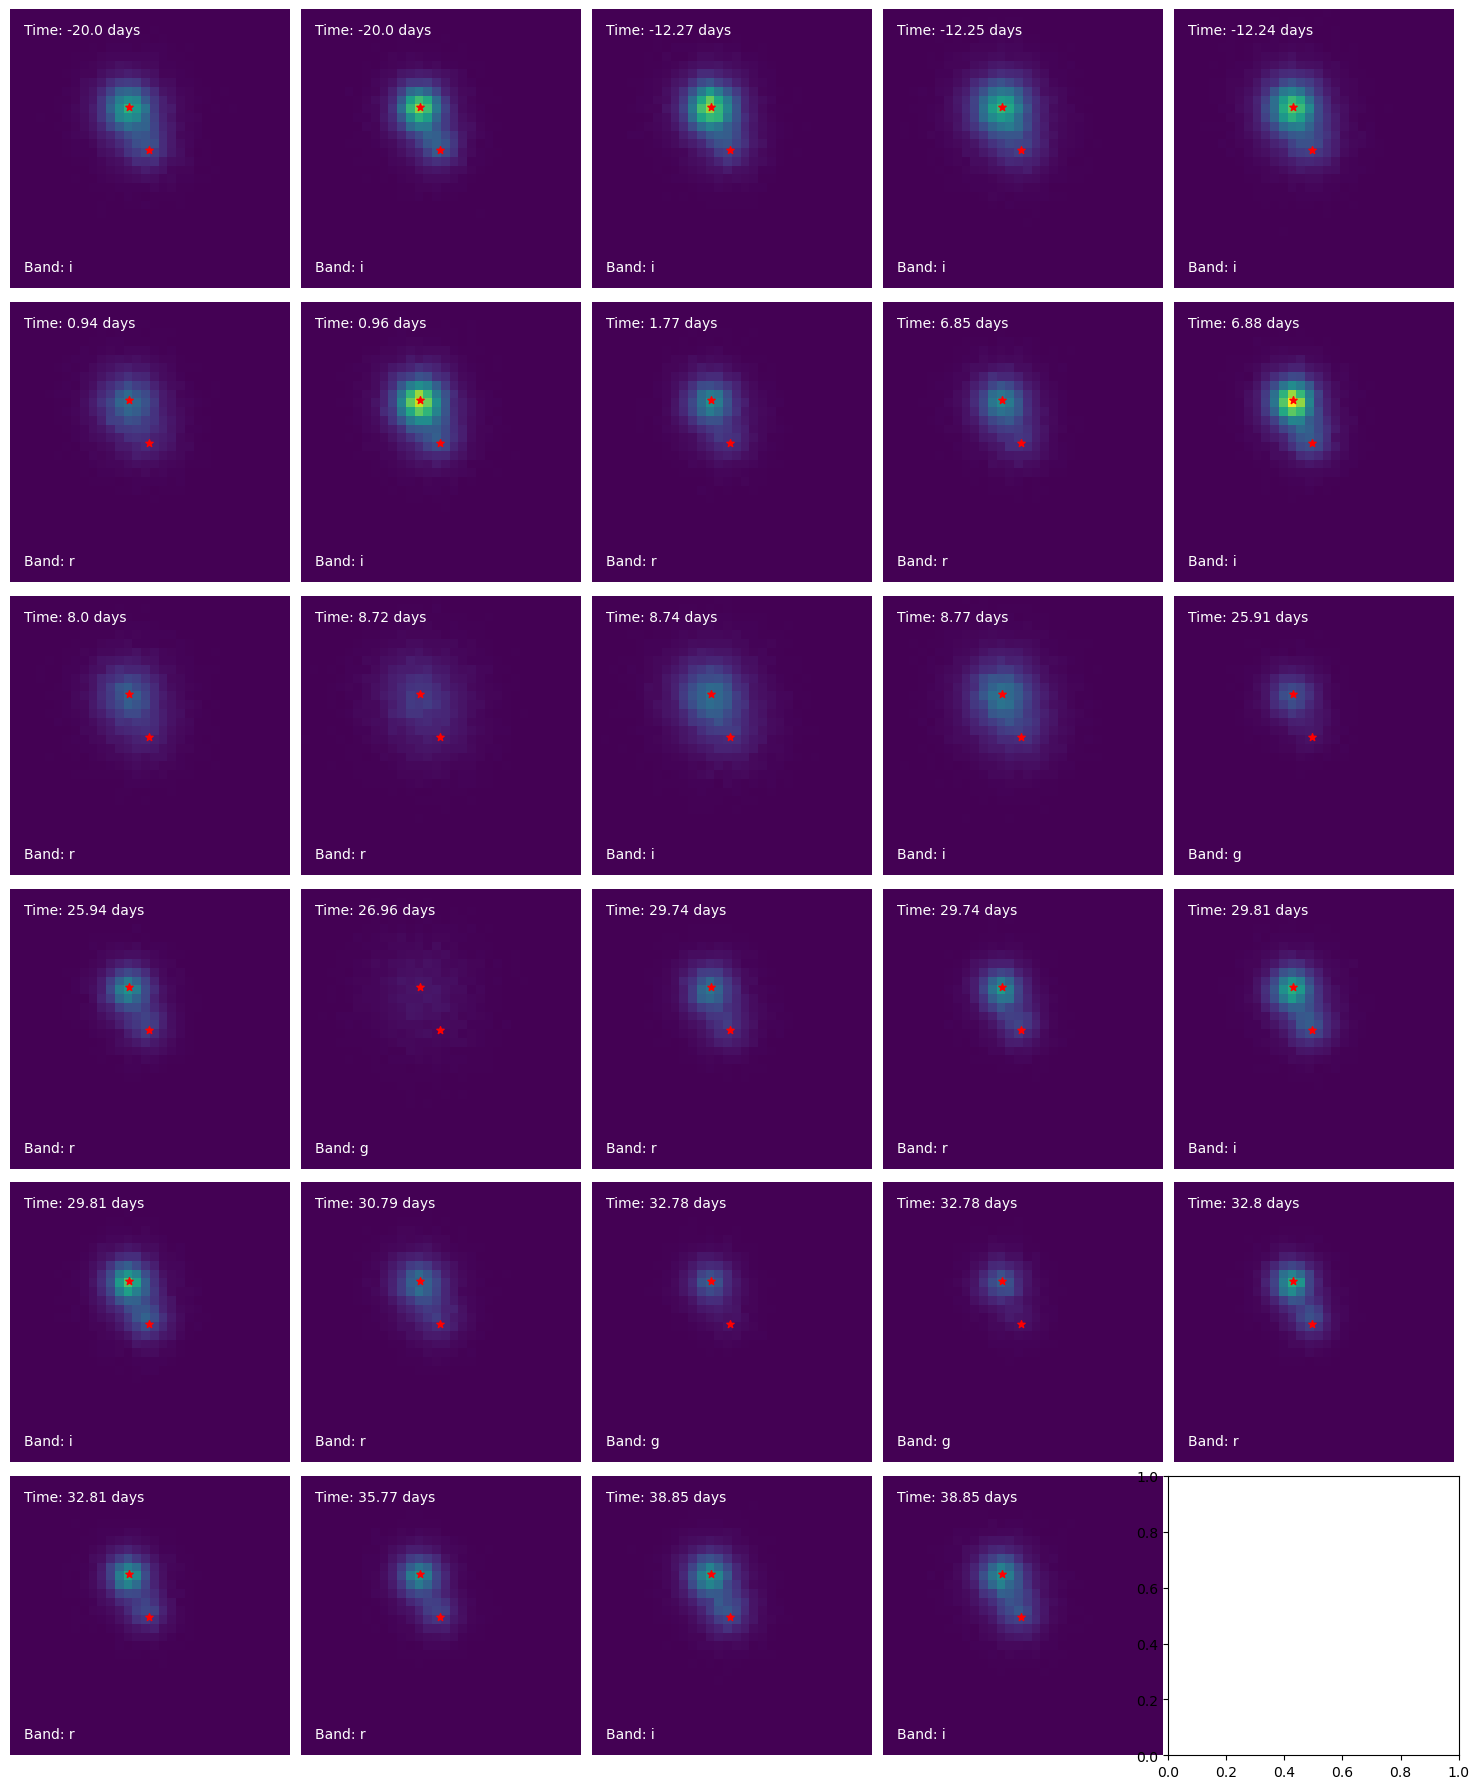

In [31]:
plot_montage = create_image_montage_from_image_list(
    num_rows=6,
    num_cols=5,
    images=images_opsim,
    time=im_times,
    image_center=pix_coord,
    band=list(images["band"]),
)

### Notes

- Can I make a separate function to calculate the zero point? It's a bit messy now within opsim_time_series_images_data.

- calexp_center just contains the object coordinates so is currently a lot of duplicates for each epoch. Maybe there's a more efficient way to save it (or maybe it doesn't matter). 

- 'injected_lens' now contains the same as 'lens', because there is no background image.

### Issues

- if ```catalog_type=None``` instead of ```"scotch"```, the ```double_sersic``` model is not defined. I get the error: ellipticity or semi-major and semi-minor axis are missing for the first light profile in galaxy_list columns.
- If the light curve goes down to very low magnitudes (~40), then I get a "lam value too large" error (see screenshot).
- ```lens_class._deflector_dict["mag_i"]}```, and ```lens_class._deflector_dict["z"]``` were not working for me, I replaced them with ```lens_class.deflector_magnitude(band='i')``` and ```lens_class.deflector_redshift```.
- In the code to generate data for the cornerplot, ```z_s``` was missing.
- The magnitudes of the supernovae are all very faint, so in the images I only see the lens galaxy. I tend to sample very low-redshift lenses and high-redshift sources. It would be great if there's a way to define a magnitude cut for point sources.

In [ ]:
# Brightness cut for SNe (23rd mag)
# Run the code without errors and for all bands (also z and y once added to ps_mag).
# Plot both light curves (with time delay) with LSST observations (new plot function?)